# KyFromAbove Explorer November Stats

This project queryies the November log files from the [KyFromAbove Open Data on AWS](https://registry.opendata.aws/kyfromabove/) bucket, and filters for users accessing oblique imagery from the [KyFromAbove Explorer](https://explore.kyfromabove.ky.gov/)   For simplicity and security reasons, I performed the query in Athena and just exported the results to CSV.  This way, I'm not providing access information to AWS, plus not having to query, paginate, and refresh a token.  Even though these log files are public requests to publicly-available data, I ommited the fields `bucketowner` and `requester`.

```sql
    SELECT "bucket_name", "requestdatetime", "remoteip", "requestid", "operation", 
           "key", "request_uri", "httpstatus", "errorcode", "bytessent", "objectsize", 
           "totaltime", "turnaroundtime", "referrer", "useragent", "hostid", "sigv", 
           "ciphersuite", "authtype", "endpoint", "tlsversion", "accesspointarn", 
           "aclrequired", "year", "month"
    FROM "s3_access_logs_db"."kyfromabove_monthly"
    WHERE year = '2024'
        and month = '11'
```


Download the [CSV]( 'https://ky.box.com/shared/static/h55nx1ca7ztcuzqvf8tu4g5q48t6lmqk.csv') (4.18 GB) data file<br>
Download the [GZIP](https://ky.box.com/shared/static/i51gwqpefsgwyooodjtuy0ima6w8u6xg.gz) (667 MB) compressed csv data file.


___

## Project Questions

 - How many GET requests is the KyFromAbove S3 Bucket receiving from the KyFromAbove Explorer.
 - How many bytes are getting sent?
 - What are the most popular images?
 - Who is using the data?

___

## Read the data using pandas

Create a python environment with the `requirements.txt` file or uncomment below to install the modules you need.

In [ ]:
# Install modules
# %pip install pandas
# %pip install matplotlib
# %pip install geopandas
# %pip install ipinfo
# %pip install folium

In [1]:
# import modueles
# import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
import ipinfo
from shapely.geometry import Point
import folium

Running this next cell can take up to a minute.

In [2]:
# add my csv file path
csv_file = './athena_output.csv'

# read as a dataframe
logs = pd.read_csv(
    csv_file, 
    header=0, 
    dtype=
    {'httpstatus': str,  # columns popped out as mixed Dtype
     'totaltime': str    # so I just assigned them as strings
                         # we can deal can deal with them later
    }
) 

# set up some print options
pd.options.display.float_format = '{:,.2f}'.format

# print a couple lines
logs.head(2)

,bucket_name,requestdatetime,remoteip,requestid,operation,key,request_uri,httpstatus,errorcode,bytessent,...,hostid,sigv,ciphersuite,authtype,endpoint,tlsversion,accesspointarn,aclrequired,year,month
0,kyfromabove,01/Nov/2024:01:06:01 +0000,205.204.186.53,QTJ7FBZE48QH5D8H,REST.GET.OBJECT,imagery/orthos/Phase3/KY_KYAPED_2022_Season2_3...,"""GET /imagery/orthos/Phase3/KY_KYAPED_2022_Sea...",206,-,8388608.0,...,rjNpjShwbo9kejjPpS7tb1qNc4gyrgM60SMJZ+M8Ljv2E0...,SigV4,ECDHE-RSA-AES128-GCM-SHA256,AuthHeader,kyfromabove.s3-accelerate.amazonaws.com,TLSv1.2,-,-,2024,11
1,kyfromabove,01/Nov/2024:00:52:13 +0000,205.204.186.53,ECTKE7FSKM0ZJAAX,REST.GET.OBJECT,imagery/orthos/Phase3/KY_KYAPED_2022_Season2_3...,"""GET /imagery/orthos/Phase3/KY_KYAPED_2022_Sea...",206,-,8388608.0,...,J++KLUf90CFdJgr1BnqftCHmgwr8BCRn3j33v7S1CbVG9L...,SigV4,ECDHE-RSA-AES128-GCM-SHA256,AuthHeader,kyfromabove.s3-accelerate.amazonaws.com,TLSv1.2,-,-,2024,11


#### Drop columns

In [3]:
# print columns
logs.columns

Index(['bucket_name', 'requestdatetime', 'remoteip', 'requestid', 'operation',
       'key', 'request_uri', 'httpstatus', 'errorcode', 'bytessent',
       'objectsize', 'totaltime', 'turnaroundtime', 'referrer', 'useragent',
       'versionid', 'hostid', 'sigv', 'ciphersuite', 'authtype', 'endpoint',
       'tlsversion', 'accesspointarn', 'aclrequired', 'year', 'month'],
      dtype='object')

to drop:

```sh

'bucket_name'     # all the same values
'requestid'       # obsure 
'request_uri'     # we know that the app is pulling the keys from s3.
'errorcode'       # most will be nulls
'useragent'       # would be neat but it doesn't mean a whole lot for this analysis
'versionid'       # obscure
'hostid'          # unnecesary
'sigv'            # for AWS governance
'ciphersuite'     #    "    "
'authtype'        #    "    "
'endpoint'        # Will all be the same once we filter 
'turnaroundtime'  # values are slightly smaller total time
'tlsversion'      # aws 
'accesspointarn'  # aws
'aclrequired'     # aws
'year'            # partition info, not needed 
'month'           # partition info, not needed

```

I also know that I'm looking for requests that come from the KyFromAbove Explorer, so I will also filter the dataframe for values `referrer=https://explore.kyfromabove.ky.gov/`.  I'm also only looking for `GET` request.  

Once I create the filters for the referrer and requests, I can drop those columns as well.


In [4]:
# drop bucket_name, year, and month
logs = logs.drop(['bucket_name','requestid', 'request_uri', 'errorcode', 'turnaroundtime',
                  'useragent','versionid', 'hostid', 'sigv', 'ciphersuite', 'authtype', 'endpoint',
                  'tlsversion', 'accesspointarn', 'aclrequired', 'year', 'month'], axis=1)

# filter for the referrer and the GET requests
logs_filtered = logs[
    (logs['referrer'] == '"https://explore.kyfromabove.ky.gov/"') &
    (logs['operation'].str.contains('GET'))
]

# drop a couple columns now that we've filtered
logs_filtered = logs_filtered.drop(['referrer', 'operation'], axis=1)

# Print some info
print(f"The unfiltered dataset has this for it's shape value: {logs.shape}\n")
print(f'The total amount of GET requests for oblique imagery for November was {logs_filtered.shape[0]: ,}.\n')  # just to get an idea of the data

logs_filtered.describe()

The unfiltered dataset has this for it's shape value: (6612895, 9)

The total amount of GET requests for oblique imagery for November was  1,833,992.



,bytessent,objectsize
count,"1,833,851.00","1,833,730.00"
mean,"102,337.34","101,727,325.87"
std,"40,875.12","63,242,133.67"
min,1.00,"16,225.00"
25%,"83,796.00","53,085,614.00"
50%,"113,088.00","84,032,917.00"
75%,"132,510.00","172,160,735.00"
max,"221,173.00","249,161,895.00"


In [5]:
# check the columns
logs_filtered.columns

Index(['requestdatetime', 'remoteip', 'key', 'httpstatus', 'bytessent',
       'objectsize', 'totaltime'],
      dtype='object')

___

## Data Cleaning and Preparation

In [ ]:
# review column datatypes
print(logs_filtered.dtypes)

#### Convert columns to proper data types

In this section, I'm going to format the `requestdatetime` values so that it's just a day/month/year without a time stamp.  Afterwards, we can drop the requestdatetime column.

In [9]:
# convert timestamp to datetime object
logs_filtered['formatted_date'] = pd.to_datetime(logs_filtered['requestdatetime'], format='%d/%b/%Y:%H:%M:%S %z')

# Format the datetime objects to "Day/Month/Year"
logs_filtered['formatted_date'] = logs_filtered['formatted_date'].dt.strftime('%m/%d/%Y')

# drop requestdatedime
logs_filtered = logs_filtered.drop('requestdatetime', axis=1)

# print a couple lines see how the date was formatted
print(logs_filtered['formatted_date'])

28         11/01/2024
29         11/01/2024
30         11/01/2024
31         11/01/2024
32         11/01/2024
              ...    
6612291    11/30/2024
6612292    11/30/2024
6612892    11/30/2024
6612893    11/30/2024
6612894    11/30/2024
Name: formatted_date, Length: 1833992, dtype: object


#### Extract the file name from key variable

In [10]:
# get basefile name
logs_filtered['filename'] = logs_filtered['key'].apply(os.path.basename)
logs_filtered['filename'].head(5)

28    Color_6146_14210.tif
29    Color_6146_14210.tif
30    Right_6144_13341.tif
31     Color_3086_4179.tif
32     Color_3086_4179.tif
Name: filename, dtype: object

In [11]:
# review column datatypes
print(logs_filtered.dtypes)

remoteip           object
key                object
httpstatus         object
bytessent         float64
objectsize        float64
totaltime          object
formatted_date     object
filename           object
dtype: object


##### Convert totaltime to numeric columns

In [12]:
# Convert totaltime to numeric and explicitly cast to float
logs_filtered.loc[:, 'totaltime'] = pd.to_numeric(logs_filtered['totaltime'], errors='coerce')

##### Copy to new dataframe so we can come back to it for different purposes

In [20]:
# create a new dataframe for neatness
logs_cleaned = logs_filtered

---

### Calculate some values for different columns

In [21]:
logs_objects = logs_cleaned[['objectsize', 'bytessent', 'totaltime']]
logs_objects.sort_values('bytessent', ascending=False)

,objectsize,bytessent,totaltime
4897156,"53,235,190.00","221,173.00",36
4943788,"53,235,190.00","221,173.00",16
4672936,"49,303,541.00","218,584.00",25
4672940,"49,303,541.00","217,930.00",80
4996649,"53,235,190.00","215,836.00",77
...,...,...,...
5431672,"55,610.00",NaN,60
5456210,"40,590.00",NaN,67
6015368,"61,668.00",NaN,8
6305766,"70,951.00",NaN,54


In [25]:
# drop nulls
pd.options.mode.copy_on_write = True 
logs_objects['bytessent'] = logs_objects['bytessent'].dropna()

# Calculate bytes sent per second
bytessent_rate = logs_objects['bytessent'] / logs_objects['totaltime']
bytessent_rate_mean = bytessent_rate.mean()
print(f'The average bytes sent rate is {bytessent_rate_mean.round(2)} bytes per second.')

The average bytes sent rate is 3191.23 bytes per second.


#### Do some grouping stats

In [37]:
# sum the number or rows for distinct filenames
total_image_get_requests = logs_cleaned[logs_cleaned['filename'].str.endswith('tif')] # filter for images only
total_get_requests = total_image_get_requests.groupby('filename').size().sort_values(ascending=False)
total_get_requests.head(20)

filename
Color_6052_19794.tif               14628
Color_6052_19795.tif                2865
Color_3121_16993.tif                2162
Color_10059_1337.tif                1989
Color_3155_8310.tif                 1800
Color_7045_41298.tif                1731
Left_6079_31571.tif                 1633
Color_20240226_11133_095834.tif     1329
Color_3121_16992.tif                1316
Color_20240225_11084_80368.tif      1299
Color_7135_11245.tif                1279
Right_4061_23097.tif                1270
Color_20240225_11084_80370.tif      1256
Color_6051_12324.tif                1205
Color_20240225_11084_80369.tif      1117
Color_2061_6050.tif                 1106
Color_2059_6990.tif                 1086
Color_10046_242622.tif              1080
Color_3155_8311.tif                 1042
Right_4056_21576.tif                1036
dtype: int64

I can see that *Color_6052_19794.tif* has the most and this makes sense, it's the default image when the app starts up.  Lets drop it.

In [38]:

total_get_requests = total_get_requests.reset_index(name='file_requests')
total_get_requests = total_get_requests[total_get_requests['filename'] != 'Color_6052_19794.tif']
total_get_requests

,filename,file_requests
1,Color_6052_19795.tif,2865
2,Color_3121_16993.tif,2162
3,Color_10059_1337.tif,1989
4,Color_3155_8310.tif,1800
5,Color_7045_41298.tif,1731
...,...,...
39267,Bwd_7127_1058.tif,1
39268,Right_9035_12198.tif,1
39269,Bwd_12029_2719.tif,1
39270,Color_7111_8129.tif,1


Http Statuses

In [40]:
http_status = logs_cleaned.groupby('httpstatus').size().reset_index(name='status_count')
print(http_status)

  httpstatus  status_count
0        200         46493
1        206       1787095
2        304           141
3        404           261
4        500             2


In [53]:
http_status['percentage']= ((http_status['status_count'] / logs_cleaned.shape[0]) *100)

for _, row in http_status.iterrows():
    print(f'HTTP Status {row['httpstatus']}: {row['percentage']:.2f}%')

HTTP Status 200: 2.54%
HTTP Status 206: 97.44%
HTTP Status 304: 0.01%
HTTP Status 404: 0.01%
HTTP Status 500: 0.00%


It looks like 99%+ of the requests to the Oblique prefix in the KyFromAbove bucket are successful.  

---

#### Print some charts

- Get the total daily requests
- print a chart of daily requests

In [54]:
total_requests = logs_cleaned.shape[0]
print(f'Total GET Request of Kentucky Oblique files from the KyFromAbove Open Data \nRegistry Bucket: {total_requests: ,} requests.\n')
total_daily_requests = logs_cleaned.groupby('formatted_date').size().reset_index(name='get_requests')
total_daily_requests

Total GET Request of Kentucky Oblique files from the KyFromAbove Open Data 
Registry Bucket:  1,833,992 requests.



,formatted_date,get_requests
0,11/01/2024,79170
1,11/02/2024,17672
2,11/03/2024,12198
3,11/04/2024,78384
4,11/05/2024,22979
5,11/06/2024,83819
6,11/07/2024,99033
7,11/08/2024,66636
8,11/09/2024,6007
9,11/10/2024,5045


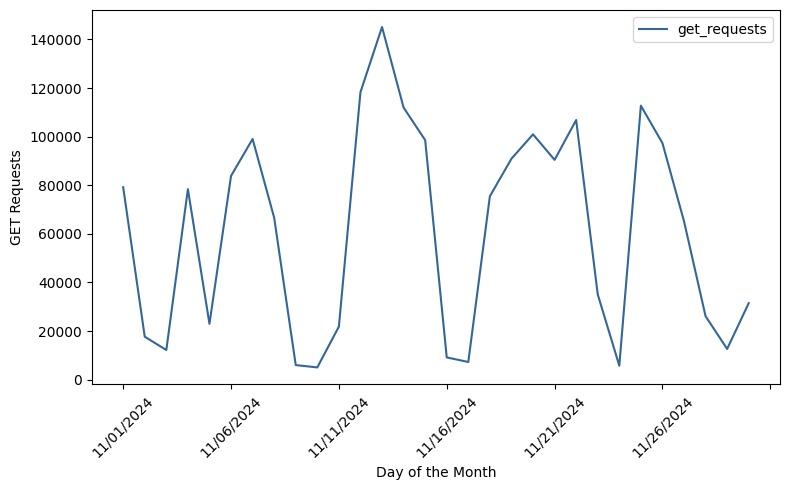

In [58]:
# plot the daily requests
total_daily_requests.plot(
    kind='line',
    x='formatted_date',
    y='get_requests',
    rot=45,
    color='#336699',
    figsize=(8,5)
).set(
    xlabel='Day of the Month',
    ylabel='GET Requests'
)

plt.tight_layout()  # Adjust layout to avoid overlapping labels
plt.show()          # Display the plot

### Who is using the data?
 
 - identify who uses the most
 - transform into a map

 For this part, we  will go use the `logs_filtered` dataframe because we want to capture all the users

In [61]:
# group by `remoteip` addresss to get users
users = logs_filtered.groupby('remoteip').size().sort_values(ascending=False).reset_index(name='requests')
users

,remoteip,requests
0,205.204.186.54,70483
1,206.214.113.217,50692
2,65.34.44.229,50346
3,205.204.186.53,44784
4,96.29.41.191,39570
...,...,...
967,66.249.70.99,1
968,174.207.167.155,1
969,40.94.105.7,1
970,66.249.70.107,1


In [62]:
users.describe()

,requests
count,972.00
mean,"1,886.82"
std,"5,625.34"
min,1.00
25%,20.00
50%,191.50
75%,975.75
max,"70,483.00"


#### Filter for variation

It looks like several users may have only tried the app once.  I'm going to set a minimum requests to 100 to only look at users  that have done more than just open the app.

In [63]:
users_filtered = users[users['requests'] >= 100]
print(users_filtered.describe())
users_filtered

       requests
count    587.00
mean   3,108.01
std    6,975.86
min      100.00
25%      239.50
50%      601.00
75%    2,294.00
max   70,483.00


,remoteip,requests
0,205.204.186.54,70483
1,206.214.113.217,50692
2,65.34.44.229,50346
3,205.204.186.53,44784
4,96.29.41.191,39570
...,...,...
582,208.102.249.228,101
583,192.69.180.163,101
584,198.102.32.250,100
585,174.202.64.247,100


### Get IP Address Geolocations

Sign up for a free account with [IPInfo](https://ipinfo.io/) to get an access token.

*This site may be blocked by your firewall or VPN.*

This process may take over a minute.

In [65]:
# ipinfo requirement: token and handler
access_token = 'bfa1fb799991f8'
handler = ipinfo.getHandler(access_token)

# create empty lists
latlng = []
city = []
region = []
postal = []

# loop through users_filtered to get location, city, region, and postal values
for ip_address in users_filtered['remoteip']:
    details = handler.getDetails(ip_address)
    # print(details.all)  # Show all available keys and values
    details_loc = details.loc
    details_city = details.city
    details_region = details.region
    details_postal = details.postal

    latlng.append(details_loc)
    city.append(details_city)
    region.append(details_region)
    postal.append(details_postal)

"""
Copy-on-Write will become the new default in pandas 3.0. This means that chained indexing will never work.
As a consequence, the SettingWithCopyWarning won’t be necessary anymore. See this section for more context.
 We recommend turning Copy-on-Write on to leverage the improvements with

` pd.options.mode.copy_on_write = True `

even before pandas 3.0 is available.
"""

pd.options.mode.copy_on_write = True 

# add output as columns
users_filtered['latlng'] = latlng
users_filtered['city'] = city
users_filtered['region'] = region
users_filtered['postal'] = postal

users_filtered

,remoteip,requests,latlng,city,region,postal
0,205.204.186.54,70483,"38.2009,-84.8733",Frankfort,Kentucky,40621
1,206.214.113.217,50692,"36.7417,-88.6367",Mayfield,Kentucky,42066
2,65.34.44.229,50346,"37.7006,-83.9738",Irvine,Kentucky,40336
3,205.204.186.53,44784,"38.2009,-84.8733",Frankfort,Kentucky,40621
4,96.29.41.191,39570,"38.1768,-85.5218",Louisville,Kentucky,40299
...,...,...,...,...,...,...
582,208.102.249.228,101,"38.9990,-84.6266",Florence,Kentucky,41042
583,192.69.180.163,101,"38.0498,-84.4586",Lexington-Fayette,Kentucky,40505
584,198.102.32.250,100,"38.9187,-77.2311",Tysons,Virginia,22027
585,174.202.64.247,100,"39.7684,-86.1580",Indianapolis,Indiana,46204


Print users not from Kentucky

In [73]:
# Filter out users from Kentucky
non_ky_users = users_filtered[users_filtered['region'] != 'Kentucky']

# Count occurrences of each region and sort by count
region_counts = non_ky_users['region'].value_counts().sort_values(ascending=False)

print(region_counts)

region
Virginia                54
Illinois                45
Ohio                    36
Indiana                 12
Tennessee               10
North Carolina           8
Colorado                 7
New York                 7
Texas                    7
Georgia                  7
Arizona                  6
Arkansas                 6
District of Columbia     5
Missouri                 5
Maryland                 4
California               4
Michigan                 4
Washington               4
Florida                  4
Minnesota                3
Wisconsin                3
Alabama                  3
Karnataka                2
Ontario                  1
Utah                     1
Manitoba                 1
Mississippi              1
West Virginia            1
Nebraska                 1
British Columbia         1
Name: count, dtype: int64


#### Karnataka?

If I were concerned with security, I might look more into this.  Probably just a bot or VPN.

#### Transform into a Geopandas DataFrame

In [74]:
# Assuming users_filtered is your existing dataframe and latlng is a column with lat,long values
# Convert latlng to Point geometries
geometry = [Point(map(float, loc.split(',')[::-1])) for loc in users_filtered['latlng']]

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(users_filtered, geometry=geometry)

# Set a CRS (Coordinate Reference System), usually "EPSG:4326" for lat/lng
gdf.set_crs("EPSG:4326", inplace=True)

# Display 
gdf

,remoteip,requests,latlng,city,region,postal,geometry
0,205.204.186.54,70483,"38.2009,-84.8733",Frankfort,Kentucky,40621,POINT (-84.8733 38.2009)
1,206.214.113.217,50692,"36.7417,-88.6367",Mayfield,Kentucky,42066,POINT (-88.6367 36.7417)
2,65.34.44.229,50346,"37.7006,-83.9738",Irvine,Kentucky,40336,POINT (-83.9738 37.7006)
3,205.204.186.53,44784,"38.2009,-84.8733",Frankfort,Kentucky,40621,POINT (-84.8733 38.2009)
4,96.29.41.191,39570,"38.1768,-85.5218",Louisville,Kentucky,40299,POINT (-85.5218 38.1768)
...,...,...,...,...,...,...,...
582,208.102.249.228,101,"38.9990,-84.6266",Florence,Kentucky,41042,POINT (-84.6266 38.999)
583,192.69.180.163,101,"38.0498,-84.4586",Lexington-Fayette,Kentucky,40505,POINT (-84.4586 38.0498)
584,198.102.32.250,100,"38.9187,-77.2311",Tysons,Virginia,22027,POINT (-77.2311 38.9187)
585,174.202.64.247,100,"39.7684,-86.1580",Indianapolis,Indiana,46204,POINT (-86.158 39.7684)


#### Plot a map

 - add a map 
 - add a tileset for background
 - add GeoDataFrame to map

In [75]:
# add map
m = folium.Map([40.01922, -97.84251], zoom_start=4)

# add GeoDataFrame
folium.GeoJson(
    gdf,
    name = 'KyFromAbove Explorer Users',
    marker=folium.Circle(radius=200, fill_color="orange", fill_opacity=0.4, weight=1),
    tooltip=folium.GeoJsonTooltip(fields=['requests', 'city']),
    popup = folium.GeoJsonPopup(fields = ['requests', 'city']),
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=True,
).add_to(m)
folium.LayerControl().add_to(m)

# display map
m